In [ ]:
#for accessing kaggle database
!pip install kaggle

In [ ]:
!pip install numpy==1.15.0
!pip install catboost

In [ ]:
#for math operations
import numpy as np
#lib for data preprocessing
import pandas as pd

In [ ]:
#Machine learning algorthm
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperperameter optimization
from sklearn.model_selection import GridSearchCV
#Support Vector Machine model
from sklearn.svm import NuSVR, SVR
#for data visualization
import matplotlib.pyplot as plt

In [ ]:
# Colab file access feature for uploading kaggle.json
from google.colab import files
#for file uploading
uploaded=files.upload()
#make a specific directory and place kaggle.json file in that dir for accessing kaggle api
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mv: target '/root/.kaggle/kaggle.json' is not a directory


In [ ]:
#competions list
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2552           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9902            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4095           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         35           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2355           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
LANL-Ear

In [ ]:
#download a specific competition dataset
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 30.2MB/s]
 93% 225M/242M [00:02<00:00, 115MB/s]
100% 242M/242M [00:02<00:00, 110MB/s]
100% 2.03G/2.03G [00:35<00:00, 27.3MB/s]



In [ ]:
#list of files in dataset 
!ls

catboost_info  sample_submission.csv  train.csv
sample_data    test.zip		      train.csv.zip


In [ ]:
#unzip train.csv
!unzip test.zip 

In [ ]:
#read data in train.csv
train=pd.read_csv('train.csv',nrows=10000000, dtype={'Accoustic_data':np.int16, 'time_to_failure':np.float64})

In [ ]:
#veiwing data in data set (checking)
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


In [ ]:
#for ploting and checking or analyzing
train_ad_sample = train['acoustic_data'].values[::100]
train_ttf_sample = train['time_to_failure'].values[::100]

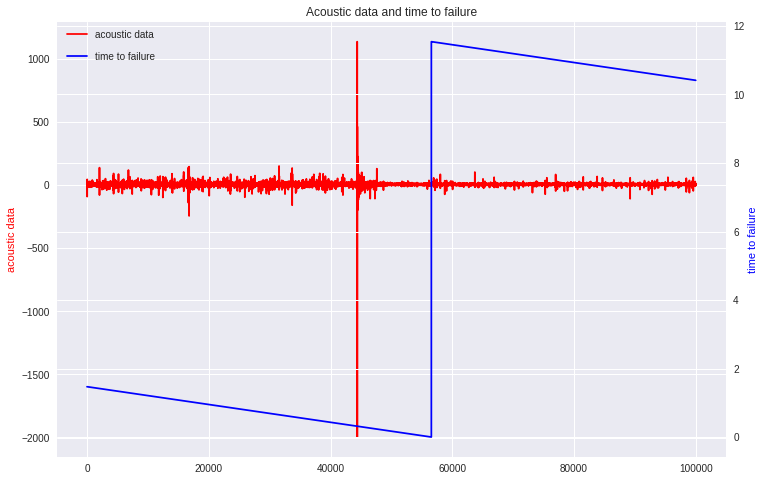

In [ ]:
#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample, train_ttf_sample, title="Acoustic data and time to failure"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)
#ploting 
plot_acc_ttf_data(train_ad_sample, train_ttf_sample)
del train_ad_sample
del train_ttf_sample

In [ ]:
#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [ ]:
#read all set of data
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
#divide data in x and y axis
X_train = pd.DataFrame()
y_train = pd.Series()
#apend features for both type 
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [ ]:

X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


In [ ]:
#now its time to use catboost
#make a pool of data
train_pool = Pool(X_train, y_train)
#give to catboost model
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
#start fiting data
m.fit(X_train, y_train, silent=True)
#print score
m.best_score_

{'learn': {'MAE': 1.7804224713035586}}

In [ ]:
df_train_10M = pd.read_csv('train.csv', nrows=200000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df_train_10M.head()

df_train_10M["index_obs"] = (df_train_10M.index.astype(float)/150000).astype(int)
train_set = df_train_10M.groupby('index_obs').agg({'acoustic_data': 'std', 'time_to_failure': 'mean'})
train_set.columns = ['acoustic_data_std', 'time_to_failure_mean']
train_set.head()


,acoustic_data_std,time_to_failure_mean
index_obs,,
0,5.101106,1.450182
1,6.588824,1.411224
2,6.967397,1.372258
3,6.922305,1.333291
4,7.301110,1.294332


In [ ]:
train_set[train_set['time_to_failure_mean'].diff() > 0].head()


,acoustic_data_std,time_to_failure_mean
index_obs,,
37,3.792706,3.349689
38,4.685087,11.510533
333,3.715960,1.351063
334,3.351572,14.158010
697,3.329402,1.350900


In [ ]:
train_set["acoustic_data_transform"] = train_set["acoustic_data_std"].clip(-20, 12).rolling(10, min_periods=1).median()

In [ ]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(train_set[["acoustic_data_transform"]], train_set["time_to_failure_mean"])

print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

Coefficients: 
 [-1.89945631]
Intercept: 
 16.863059468449016


In [ ]:
submission_file = pd.read_csv('sample_submission.csv')
submission_file.head()

,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0
2,seg_00184e,0
3,seg_003339,0
4,seg_0042cc,0


In [ ]:
for index, seg_id in enumerate(submission_file['seg_id']):
    seg = pd.read_csv(str(seg_id) + '.csv')
    x = seg['acoustic_data'].values
    std_x = max(-20, min(12, np.std(x)))
    submission_file.loc[index, "time_to_failure"] = max(0, regr.intercept_ + regr.coef_ * std_x)
    del seg

In [ ]:
submission_file.to_csv('submission.csv', index=False)